In [30]:
import pandas as pd
import numpy as np

In [31]:
airlines = pd.read_csv('./data/airlines.dat', header=None, dtype=str)
airports = pd.read_csv('./data/airports.dat', header=None, dtype=str)
routes = pd.read_csv('./data/routes.dat', header=None, dtype=str)

In [32]:
airports.columns = ["id", "name", "city", "country", "code", "icao", "latitude", "longitude", "altitude", "offset", "dst", "timezone"]
airlines.columns = ["id", "name", "alias", "iata", "icao", "callsign", "country", "active"]
routes.columns = ["airline", "airline_id", "source", "source_id", "dest", "dest_id", "codeshare", "stops", "equipment"]

In [33]:
airports.head()

,id,name,city,country,code,icao,latitude,longitude,altitude,offset,dst,timezone
0,1,Goroka,Goroka,Papua New Guinea,GKA,AYGA,-6.081689,145.391881,5282,10,U,Pacific/Port_Moresby
1,2,Madang,Madang,Papua New Guinea,MAG,AYMD,-5.207083,145.7887,20,10,U,Pacific/Port_Moresby
2,3,Mount Hagen,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789,144.295861,5388,10,U,Pacific/Port_Moresby
3,4,Nadzab,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569828,146.726242,239,10,U,Pacific/Port_Moresby
4,5,Port Moresby Jacksons Intl,Port Moresby,Papua New Guinea,POM,AYPY,-9.443383,147.22005,146,10,U,Pacific/Port_Moresby


In [34]:
airlines.head()

,id,name,alias,iata,icao,callsign,country,active
0,1,Private flight,\N,-,NaN,NaN,NaN,Y
1,2,135 Airways,\N,NaN,GNL,GENERAL,United States,N
2,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
3,4,2 Sqn No 1 Elementary Flying Training School,\N,NaN,WYT,NaN,United Kingdom,N
4,5,213 Flight Unit,\N,NaN,TFU,NaN,Russia,N


In [35]:
routes.head()

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [36]:
len(routes[routes.airline_id == "\N"]), len(routes[routes.airline_id == "\\N"])

(678, 678)

In [37]:
routes.shape, airlines.shape, airports.shape

((67663, 9), (6048, 8), (8107, 12))

In [38]:
routes = routes[routes["airline_id"] != "\\N"]

In [39]:
routes.shape

(66985, 9)

In [40]:
import math

def haversine(lon1, lat1, lon2, lat2):
    # Convert coordinates to floats.
    lon1, lat1, lon2, lat2 = [float(lon1), float(lat1), float(lon2), float(lat2)]
    # Convert to radians from degrees.
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # Compute distance.
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    km = 6367 * c
    return km

In [41]:
def calc_dist(row):
    dist = 0
    try:
        # Match source and destination to get coordinates.
        source = airports[airports["id"] == row["source_id"]].iloc[0]
        dest = airports[airports["id"] == row["dest_id"]].iloc[0]
        # Use coordinates to compute distance.
        dist = haversine(dest["longitude"], dest["latitude"], source["longitude"], source["latitude"])
    except (ValueError, IndexError):
        pass
    return dist

In [42]:
route_lengths = routes.apply(calc_dist, axis=1)

In [43]:
route_lengths.describe()

count    66985.000000
mean      1848.329039
std       2020.452033
min          0.000000
25%        627.522541
50%       1197.544384
75%       2172.606194
max      13799.491740
dtype: float64

(array([  1.88370000e+04,   1.88060000e+04,   1.15850000e+04,
          5.70400000e+03,   3.78000000e+03,   1.80200000e+03,
          9.06000000e+02,   7.22000000e+02,   9.09000000e+02,
          8.79000000e+02,   6.44000000e+02,   7.08000000e+02,
          5.17000000e+02,   4.64000000e+02,   2.04000000e+02,
          2.24000000e+02,   1.52000000e+02,   6.80000000e+01,
          5.80000000e+01,   1.60000000e+01]),
 array([     0.        ,    689.97458702,   1379.94917403,   2069.92376105,
          2759.89834807,   3449.87293508,   4139.8475221 ,   4829.82210912,
          5519.79669613,   6209.77128315,   6899.74587017,   7589.72045718,
          8279.6950442 ,   8969.66963121,   9659.64421823,  10349.61880525,
         11039.59339226,  11729.56797928,  12419.5425663 ,  13109.51715331,
         13799.49174033]),
 <a list of 20 Patch objects>)

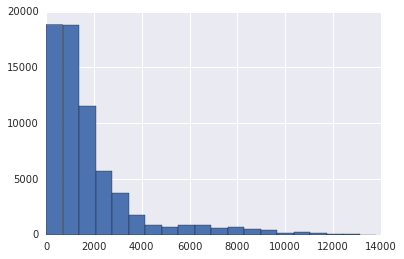

In [44]:
# Histogram

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(route_lengths, bins=20)

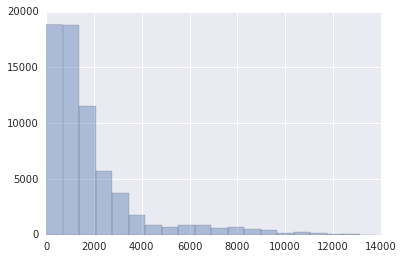

In [45]:
import seaborn
seaborn.distplot(route_lengths, bins=20, kde=0)

In [49]:
# Bar Chart
# Put relevant columns into a dataframe.
route_length_df = pd.DataFrame({"length": route_lengths, "id": routes["airline_id"]})
# Compute the mean route length per airline.
airline_route_lengths = route_length_df.groupby("id").aggregate(np.mean)
# Sort by length so we can make a better chart.
airline_route_lengths = airline_route_lengths.sort_values(by="length", ascending=False)

In [50]:
airline_route_lengths.head(10)

,length
id,
11806,7260.803336
3201,6332.122405
1008,5861.977268
1299,4943.941690
2183,4729.250717
2417,4707.871646
5479,4649.944174
11814,4504.587573
225,4434.483659


<Container object of 540 artists>

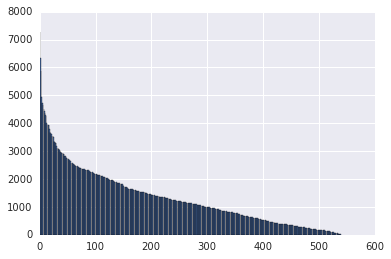

In [51]:
plt.bar(range(airline_route_lengths.shape[0]), airline_route_lengths["length"])

In [52]:
def lookup_name(row):
    try:
        # Match the row id to the id in the airlines dataframe so we can get the name.
        name = airlines["name"][airlines["id"] == row["id"]].iloc[0]
    except (ValueError, IndexError):
        name = ""
    return name

In [54]:
# Add the index (the airline ids) as a column.
airline_route_lengths["id"] = airline_route_lengths.index.copy()
# Find all the airline names.
airline_route_lengths["name"] = airline_route_lengths.apply(lookup_name, axis=1)
# Remove duplicate values in the index.
airline_route_lengths.index = range(airline_route_lengths.shape[0])

In [55]:
airline_route_lengths.head()

,length,id,name
0,7260.803336,11806,Compagnie Africaine d\\'Aviation
1,6332.122405,3201,LAN Argentina
2,5861.977268,1008,Albanian Airlines
3,4943.941690,1299,Arkefly
4,4729.250717,2183,Emirates


In [60]:
from bokeh.io import output_notebook
from bokeh.charts import Bar, show, output_file

output_notebook()
#output_file('bar1.html')
p = Bar(airline_route_lengths.ix[:20,:], 'name', values='length', title="Average airline route lengths", legend=None)
show(p)

Loading BokehJS ...

In [73]:
# Horizontal Bar Chart

long_routes = len([k for k in route_lengths if k > 10000]) / float(len(route_lengths))
medium_routes = len([k for k in route_lengths if k < 10000 and k > 2000]) / float(len(route_lengths))
short_routes = len([k for k in route_lengths if k < 2000]) / float(len(route_lengths))

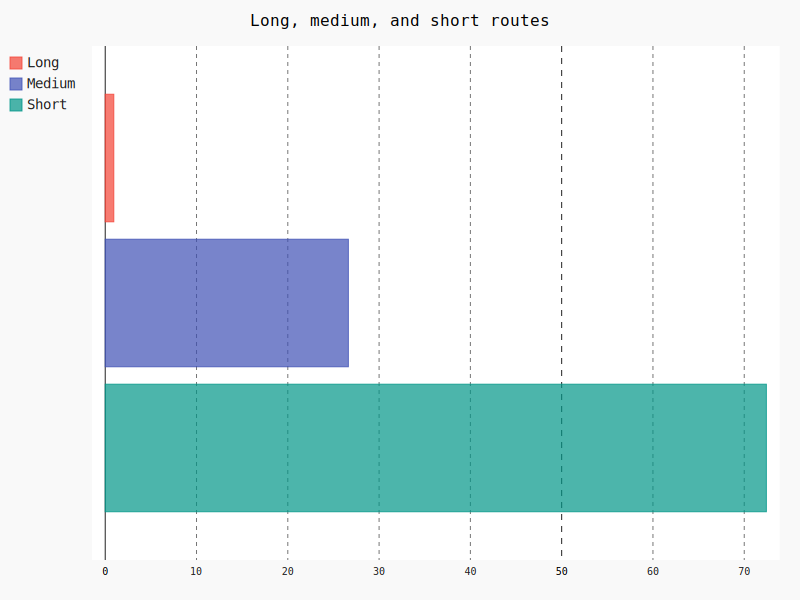

In [74]:
import pygal
from IPython.display import SVG

chart = pygal.HorizontalBar()
chart.title = 'Long, medium, and short routes'
chart.add('Long', long_routes * 100)
chart.add('Medium', medium_routes * 100)
chart.add('Short', short_routes * 100)
chart.render_to_file('routes.svg')
SVG(filename='routes.svg')

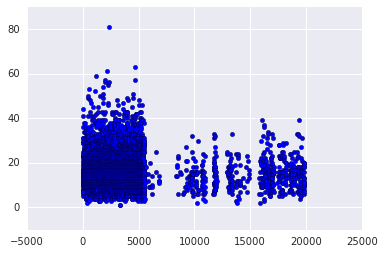

In [75]:
# Scatter plot
name_lengths = airlines["name"].apply(lambda x: len(str(x)))
plt.scatter(airlines["id"].astype(int), name_lengths)

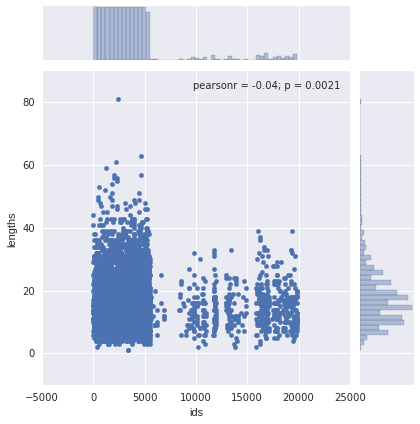

In [77]:
data = pd.DataFrame({"lengths": name_lengths, "ids": airlines["id"].astype(int)})
seaborn.jointplot(x="ids", y="lengths", data=data)